# Emotions classifier 

## Project scope

<p>The scope of this project is to create a classifier of human emotion expressed through text obtained from publicly available tweets. </p>

## Imports

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re
import contractions
from nltk.stem import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Exploratory data analysis

<p>Let's get to actually know our data and determine what we'll have to do with it in the preprocessing section, before we can proceed to training a classifier model on it.</p>

In [2]:
tweets_data = pd.read_csv('./Data/tweet_emotions.csv')

In [3]:
tweets_data.head(10)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


<p>I see we'll have to deal with special characters, elongated leters, inaccurate grammar, etc. Let's see how big is the dataset. </p>

In [4]:
tweets_data.describe()

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


<p>Ok, we have 40000 records inside of our dataset, which means that we'll have to, eventually, break down the preprocessing iterative part into batches of smaller data, so that it all gets done quickly and less costly in terms of memory and processing power. </p>

<p>Let's see all of our sentiment classes, this is what we'll train our model to predict based on an input text.</p>

In [5]:
tweets_data['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

<p>Ok, apparently we'll have to do multi-class classification, so logistic regression is out of the question for our classification model. Perhaps we could use K-Nearest Neighbour or a naive bayes classifier? Maybe even a random forest one? </p>

<p>We should also see if our dataset, in terms of sentiments, is balanced i.e. if the dataset does not contain mostly enthusiasm or some other sentiment. </p>

<AxesSubplot: >

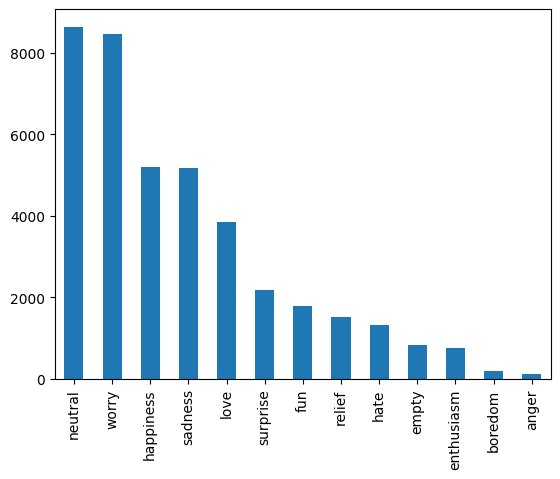

In [6]:
tweets_data['sentiment'].value_counts().plot(kind='bar')

<p>Obviously the model, with the current data, will be incredibly biased toward neutral and worry emotions because they make up most of the dataset. That's a problem we have to deal with. One way we could do that is to duplicate the lower values until they get up to the scale of the neutral and worry sentiments? Another one, which to me seems a lot more practical, is to use weighted loss for the classification model. Basically, we'll use scikit learn and tell it to assign a weight to all the sentiments that is inversely proportional to the sentiment's frequency in the dataset.</p>

# Data preprocessing

<p> First, we'll have to seperate the tweets into words, and then remove the stopwords and make all the words lower case, so that we don't get any unpleasant surprises later on. </p>

In [7]:
tweets = tweets_data['content']

In [8]:
words_tokenized_tweets = [word_tokenize(tweet_sentence) for tweet_sentence in tweets]

In [35]:
words_tokenized_tweets[0:5]

[['@',
  'tiffanylue',
  'i',
  'know',
  'i',
  'was',
  'listenin',
  'to',
  'bad',
  'habit',
  'earlier',
  'and',
  'i',
  'started',
  'freakin',
  'at',
  'his',
  'part',
  '=',
  '['],
 ['Layin',
  'n',
  'bed',
  'with',
  'a',
  'headache',
  'ughhhh',
  '...',
  'waitin',
  'on',
  'your',
  'call',
  '...'],
 ['Funeral', 'ceremony', '...', 'gloomy', 'friday', '...'],
 ['wants', 'to', 'hang', 'out', 'with', 'friends', 'SOON', '!'],
 ['@',
  'dannycastillo',
  'We',
  'want',
  'to',
  'trade',
  'with',
  'someone',
  'who',
  'has',
  'Houston',
  'tickets',
  ',',
  'but',
  'no',
  'one',
  'will',
  '.']]

In [10]:
no_stopwords = [[word.lower() for word in tweet if word not in set(stopwords.words('english'))] for tweet in words_tokenized_tweets ]

In [11]:
no_stopwords[0]

['@',
 'tiffanylue',
 'know',
 'listenin',
 'bad',
 'habit',
 'earlier',
 'started',
 'freakin',
 'part',
 '=',
 '[']

<p>It seems to be working, no stopwords seem to be present here. Now, let's remove anything that's not a word (I assume that excalamation and question marks do not show that much of an emotion as the individual words used in the context of the entire tweet). We'll use a regex for that. </p>

In [12]:
words_only_sentences = [[word for word in tweet if not re.match('\W+|\d+', word) ] for tweet in no_stopwords ]

In [13]:
words_only_sentences[0:5]

[['tiffanylue',
  'know',
  'listenin',
  'bad',
  'habit',
  'earlier',
  'started',
  'freakin',
  'part'],
 ['layin', 'n', 'bed', 'headache', 'ughhhh', 'waitin', 'call'],
 ['funeral', 'ceremony', 'gloomy', 'friday'],
 ['wants', 'hang', 'friends', 'soon'],
 ['dannycastillo',
  'we',
  'want',
  'trade',
  'someone',
  'houston',
  'tickets',
  'one']]

<p> It seems to have worked, now we have to take care of the so called contraction words, such as: don't, can't, won't, etc. We'll expand them like so: don't - do not, can't - cannot, etc. </p>

In [14]:
words_only_sentences = [[contractions.fix(word) for word in tweet] for tweet in words_only_sentences ]

In [15]:
words_only_sentences[0:5]

[['tiffanylue',
  'know',
  'listenin',
  'bad',
  'habit',
  'earlier',
  'started',
  'freakin',
  'part'],
 ['layin', 'n', 'bed', 'headache', 'ughhhh', 'waitin', 'call'],
 ['funeral', 'ceremony', 'gloomy', 'friday'],
 ['wants', 'hang', 'friends', 'soon'],
 ['dannycastillo',
  'we',
  'want',
  'trade',
  'someone',
  'houston',
  'tickets',
  'one']]

<p> We have to, finally, lemmatize every word in our dataset. That means we'll turn every word into its base form, based on a look-up in a dictionary -> Running - run, planes -> plane, etc. The reason we want to use lemmatization over stemmatization is that lemmatization, at least in my humble experience, seems to give us words that make sense and are grammatically correct. On the other hand, stemmatization is known to give us results, such as: Flying -> Flyi, Running -> Runn, etc. We want to avoid that, even at the price of a more computationally expensive method (lemmatization).</p>

<p> We will use NLTK's word net lemmatizer. </p>

In [22]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [17]:
lemmatized_verbs_words = [[lemmatizer.lemmatize(word, pos='v') for word in sentence] for sentence in words_only_sentences]

In [31]:
lemmatized_verbs_words[0:5]

[['tiffanylue',
  'know',
  'listenin',
  'bad',
  'habit',
  'earlier',
  'start',
  'freakin',
  'part'],
 ['layin', 'n', 'bed', 'headache', 'ughhhh', 'waitin', 'call'],
 ['funeral', 'ceremony', 'gloomy', 'friday'],
 ['want', 'hang', 'friends', 'soon'],
 ['dannycastillo',
  'we',
  'want',
  'trade',
  'someone',
  'houston',
  'ticket',
  'one']]

<p>It seems to be working for the correctly written verbs. A problem that arrises here is that we have incorrect words, such as "layin" which is supposed to be "laying". The lemmatizer doesn't finy such a word in WordNet and returns the original input (as specified in the documentation). One way I can think of dealing with that problem is if we have a COMPLETE list of all words in english and all their forms in all tenses and applying an edit distance algorithm over them, as to see which word is closest to the current word. Levenshtein distance would do well in that case, but we won't go as deep in this notebook and we'll leave that as it is. </p>

Next, we'll lematize everything, but the verbs (as we've already lemmatized them earlier). If you notice we do not pass any pos(part of speech) parameter to the lemmatizer here, that is because if we don't specify the POS tag to lemmatize, everything else but the verbs is lemmatized. </p>

In [32]:
lemmatized_everything_else_words = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in lemmatized_verbs_words]

In [34]:
lemmatized_everything_else_words[0:5]

[['tiffanylue',
  'know',
  'listenin',
  'bad',
  'habit',
  'earlier',
  'start',
  'freakin',
  'part'],
 ['layin', 'n', 'bed', 'headache', 'ughhhh', 'waitin', 'call'],
 ['funeral', 'ceremony', 'gloomy', 'friday'],
 ['want', 'hang', 'friend', 'soon'],
 ['dannycastillo',
  'we',
  'want',
  'trade',
  'someone',
  'houston',
  'ticket',
  'one']]

<p>Let's now join the data together so that each sentence is complete and it refers to the correct index in the original data frame, this is because we'll later create a new data frame and we'll want to link each tweet with its original sentiment. </p>

In [42]:
joined_preprocessed_tweets = [" ".join(tweet_words) for tweet_words in lemmatized_everything_else_words]

In [53]:
joined_preprocessed_tweets[0:5]

['tiffanylue know listenin bad habit earlier start freakin part',
 'layin n bed headache ughhhh waitin call',
 'funeral ceremony gloomy friday',
 'want hang friend soon',
 'dannycastillo we want trade someone houston ticket one']

<p>Now, we'll create the preprocessed data frame that we'll use for the training of our models later on. </p>

In [51]:
tweets_preprocessed = pd.DataFrame({'content': joined_preprocessed_tweets, 'sentiment': tweets_data['sentiment']})

In [52]:
tweets_preprocessed

,content,sentiment
0,tiffanylue know listenin bad habit earlier sta...,empty
1,layin n bed headache ughhhh waitin call,sadness
2,funeral ceremony gloomy friday,sadness
3,want hang friend soon,enthusiasm
4,dannycastillo we want trade someone houston ti...,neutral
...,...,...
39995,johnlloydtaylor,neutral
39996,happy mother day all love,love
39997,happy mother day mommy woman man long someone day,love
39998,niariley wassup beautiful follow me peep out m...,happiness


<p> I think we're ready with the preprocessing, we've achieved what we set out to achieve earlier in this section. Let's move on to the models building.</p>

# Models buidling

<p> As mentioned at the beginning of this notebook, we'll use either K-Nearest Neighbour(KNN) or a Naive Bayes Classificator, because it seems that these two are well-suited for our task (multi-class classification). Let's take a look at each of them, starting with K-Nearest Neighbour.</p>

## K-Nearest Neighbour (KNN)

<p>KNN is a supervised learning algorithm, which means that it needs a human (or any other sentient, intelligent being/creature/machine for that matter) to "show" it the correct way to classify whatever it's supposed to classify - be it images, user profiles, fake profiles, etc. </p>

<p>The reason we should consider KNN is because it does very well on classification tasks such as our task. It also does well with large sets of data, as most supervised learning algorithms in fact.</p>

### K-Nearest Neighbour inner workings

<p>Let's see what's behind the scenes of KNN, and what exactly does "K" stand for. </p>

<p>When we plot our data points on a plot for the purpose of classification it usually tends to follow patterns, where a certain class data point positions itself around similar class data points, thus forming a cluster. Whenever we want to classify a new data, say a tweet as in our case, we just turn the data into numerical form(if it is not in such a form yet), plot it on that plot and we look for the closest neighbours to our data point. This is where "K" comes in. K stands for the amount of closest neighbors we want. The cluster of a given class of closest neighbours to our data points is considered to be the predicted class of our input data. As for the way the distance between each data point and our input data, it is euclidean distance and it uses the euclidean distance formula. It's probably appropriate to mention that it's also a good practice to set "K" to odd values such as 3 or 5, so that we don't get a tie between a couple of classes. Hopefully, that's clear enough. Let's get to the model building part. </p>

### K-Nearest Neighbour implementation

In [39]:
Y =  lemmatized_everything_else_words

In [37]:
KNN_Classifier = KNeighborsClassifier(n_neighbors=3)

In [ ]:
KNN_Classifier.fit(X,y)